In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import sys
import os
import torch
from agent.drl_utrans import DrlUTransAgent

In [2]:
# ──────────────────────────────────────────────────────────
# 1. Download daily OHLCV data (adjusted close already used)
# ──────────────────────────────────────────────────────────
df = yf.download("AAPL", start="2010-01-01", end="2020-08-25")

# Keep only the columns we need and ensure they’re floats
df = df[["Open", "High", "Low", "Close", "Volume"]].astype(float)

# ──────────────────────────────────────────────────────────
# 2. Helper functions for the indicators we need
# ──────────────────────────────────────────────────────────
def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def macd(series: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):
    fast_ema = ema(series, fast)
    slow_ema = ema(series, slow)
    macd_line = fast_ema - slow_ema
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def cci(high, low, close, period: int = 20):
    tp = (high + low + close) / 3
    sma = tp.rolling(period).mean()
    mad = tp.rolling(period).apply(lambda x: np.fabs(x - x.mean()).mean(), raw=True)
    return (tp - sma) / (0.015 * mad)

def williams_r(high, low, close, period: int = 14):
    highest_high = high.rolling(period).max()
    lowest_low = low.rolling(period).min()
    return -100 * (highest_high - close) / (highest_high - lowest_low)

def bollinger(close, period: int = 20, mult: float = 2.0):
    ma = close.rolling(period).mean()
    std = close.rolling(period).std()
    upper = ma + mult * std
    lower = ma - mult * std
    return upper, lower

def kdj(high, low, close, period: int = 9, k_smooth: int = 3, d_smooth: int = 3):
    low_min  = low.rolling(period).min()
    high_max = high.rolling(period).max()
    rsv = 100 * (close - low_min) / (high_max - low_min)
    k = rsv.ewm(alpha=1.0/k_smooth, adjust=False).mean()
    d = k.ewm(alpha=1.0/d_smooth, adjust=False).mean()
    j = 3 * k - 2 * d
    return k, d, j

# ──────────────────────────────────────────────────────────
# 3. Compute all 14 features
# ──────────────────────────────────────────────────────────
df["macd"], df["macd_signal"], df["macd_hist"] = macd(df["Close"])
df["cci"]          = cci(df["High"], df["Low"], df["Close"])
df["wr_14"]        = williams_r(df["High"], df["Low"], df["Close"])
df["boll_upper"], df["boll_lower"] = bollinger(df["Close"])
df["kdj_k"], df["kdj_d"], df["kdj_j"] = kdj(df["High"], df["Low"], df["Close"])
df["ema20"]        = ema(df["Close"], 20)
df["close_delta"]  = df["Close"].diff()
df["open_close_diff"] = df["Open"] - df["Close"]

# ──────────────────────────────────────────────────────────
# 4. Drop initial NaNs caused by rolling windows
# ──────────────────────────────────────────────────────────
df.dropna(inplace=True)

# ──────────────────────────────────────────────────────────
# 5. Assemble feature matrix (shape: [T, 14])
# ──────────────────────────────────────────────────────────
feature_cols = [
    "macd", "macd_signal", "macd_hist",      # 3
    "cci",                                   # 1  -> 4
    "wr_14",                                 # 1  -> 5
    "boll_upper", "boll_lower",              # 2  -> 7
    "kdj_k", "kdj_d", "kdj_j",               # 3  ->10
    "ema20",                                 # 1  ->11
    "close_delta",                           # 1  ->12
    "open_close_diff",                       # 1  ->13
    # One extra to hit 14 — use RSI-14 for variety
]
# Simple RSI-14 implementation
delta = df["Close"].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / loss.replace(0, np.nan)
df["rsi_14"] = 100 - 100 / (1 + rs)
feature_cols.append("rsi_14")                 # 14th feature

# Final feature tensor
data_features = pd.DataFrame(df[feature_cols].values.astype(np.float32))
data_features.fillna(0, inplace=True)  # Ensure no NaNs remain

print(f"Feature matrix shape: {data_features.shape}")  # Should be [T, 14]


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Feature matrix shape: (2660, 14)


In [4]:
class PaperSingleStockEnv:
    """
    Single-stock environment implementing Algorithm 1 with
    proper NaN/zero-division protection.
    """
    def __init__(
        self,
        features: np.ndarray,
        prices: np.ndarray,
        window_size: int = 12,
        ic: int = 500,
    ):
        assert len(features) == len(prices)
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()
        elif not isinstance(features, np.ndarray):
            features = np.asarray(features)
        self.X = features.astype(np.float32)
        self.P = prices.astype(np.float32)
        self.L = window_size
        self.IC0 = ic
        self.max_ptr = len(self.X) - 1  # last usable index for P_t
        self.reset()

    # ──────────────────────────────── helpers
    def _state(self):
        return self.X[self.ptr - self.L : self.ptr].astype(np.float32)

    def _done(self):
        # need P_{t+1} for reward; stop at max_ptr-1
        return self.ptr >= self.max_ptr

    # ──────────────────────────────── Gym API
    def reset(self):
        self.ptr = self.L               # first index that has a full window
        self.H  = 0                     # shares held
        self.I  = 0.0                   # invested amount $
        self.IC = self.IC0              # capacity in shares
        return self._state()

    def step(self, act_weight):
        """
        action 0 buy, 1 sell, 2 hold
        weight in [0,1] (ignored for hold)
        """
        action, w = act_weight
        P_t = self.P[self.ptr]

        # --- current cost basis (only defined if H>0)
        C_t = (self.I / self.H) if self.H > 0 else 0.0
        reward = 0.0

        # ========== BUY =====================================================
        if action == 0 and (self.IC - self.H) >= 100:
            B = max(100, round(((self.IC - self.H) * w) / 100) * 100)
            self.H += B
            self.I += P_t * B                # increase invested capital
            C_t = self.I / self.H            # new cost basis
            reward = (C_t - P_t) * B         # Eq.(5) buy reward
            self.IC -= B                     # reduce remaining capacity

        # ========== SELL ====================================================
        elif action == 1 and self.H > 0:
            S = max(100, round((self.H * w) / 100) * 100)
            S = min(S, self.H)               # cannot sell more than we hold
            self.H -= S
            self.I -= C_t * S                # remove cost for sold shares
            reward = (P_t - C_t) * S         # Eq.(5) sell reward
            self.IC += S                     # capacity freed

        # ========== HOLD ====================================================
        else:  # hold or invalid buy/sell
            if self.H > 0:
                reward = (P_t - C_t) * self.H  # unrealised P/L
            # else reward stays 0

        # ------------- advance time -------------
        self.ptr += 1
        done = self._done()
        next_state = (
            self._state() if not done else np.zeros_like(self._state().astype(np.float32))
        )
        return next_state, float(reward), done, {}


In [ ]:
env = PaperSingleStockEnv(
    features=data_features,
    prices=df["Close"].values,
    window_size=12,
    ic=500,
)
agent = DrlUTransAgent(state_dim=(12, data_features.shape[1]), 
                       lr=0.001, batch_size=20, memory_size=10000,
                       target_update_freq=100, epsilon_start=1.0,
                       epsilon_end=0.1, epsilon_decay=0.95)

# Train the agent for a small number of episodes (e.g., 5 episodes)
agent.train(env, num_episodes=5)
print("Training completed.")

# Evaluate the trained agent with greedy policy (epsilon = 0) and track cumulative return
agent.epsilon = 0.0
state = env.reset()
wealth = 0.0
cumulative_returns = [wealth]
while True:
    action, weight = agent.select_action(torch.tensor(state, dtype=torch.float32))
    next_state, reward, done, _ = env.step((action, weight))
    wealth += reward  # accumulate profit (assuming initial wealth 0 for simplicity)
    cumulative_returns.append(wealth)
    state = next_state
    if done:
        break


/var/folders/zz/x5lprhj10ngbk5lbltlbl7q80000gn/T/ipykernel_94757/1328435168.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return next_state, float(reward), done, {}
/var/folders/zz/x5lprhj10ngbk5lbltlbl7q80000gn/T/ipykernel_94757/1328435168.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return next_state, float(reward), done, {}
/var/folders/zz/x5lprhj10ngbk5lbltlbl7q80000gn/T/ipykernel_94757/1328435168.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.

Training completed.


n_steps: 2647
unique reward deltas: {np.float64(0.0), np.float64(4.76837158203125e-05), np.float64(-4.76837158203125e-05), np.float64(3.1558990478515625), np.float64(3.0255794525146484), np.float64(5.710792541503906), np.float64(5.439853668212891), np.float64(6.090736389160156), np.float64(8.716583251953125), np.float64(9.075355529785156), np.float64(-0.26035308837890625), np.float64(1.4133453369140625), np.float64(9.437084197998047), np.float64(13.794708251953125), np.float64(1.9868850708007812), np.float64(15.828800201416016), np.float64(3.66668701171875), np.float64(15.878677368164062), np.float64(18.093109130859375), np.float64(19.41542625427246), np.float64(20.587158203125), np.float64(21.0080623626709), np.float64(22.989749908447266), np.float64(20.586013793945312), np.float64(19.29483413696289), np.float64(19.204425811767578), np.float64(19.264984130859375), np.float64(27.129268646240234), np.float64(28.200817108154297), np.float64(29.19759750366211), np.float64(28.6214828491210

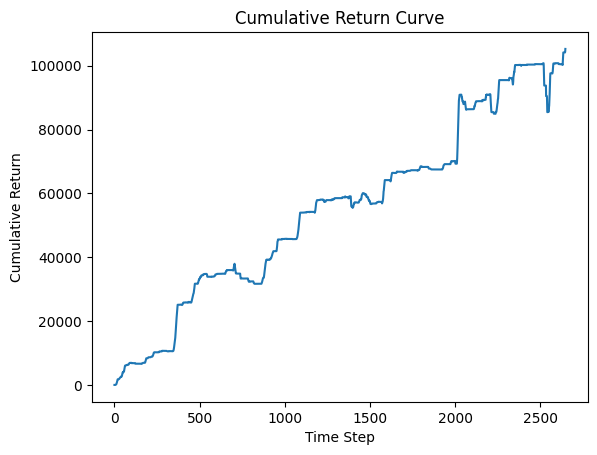

In [6]:
print("n_steps:", len(cumulative_returns) - 1)
unique_rewards = set(np.diff(cumulative_returns))
print("unique reward deltas:", unique_rewards)

# Plot the cumulative return curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(cumulative_returns)
plt.title("Cumulative Return Curve")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.show()
